In [ ]:
Z_DIM = 3

### 1. Load dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time


import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

In [ ]:
!unzip -q /content/drive/MyDrive/thesis/pendulum/pendulum.zip -d .

In [ ]:
class Synthetic(Dataset):
    def __init__(self, root, dataset="train"):
        root = root + "/" + dataset

        imgs = os.listdir(root)

        self.dataset = dataset

        self.imgs = [os.path.join(root, k) for k in imgs]
        self.imglabel = [list(map(int, k[:-4].split("_")[1:])) for k in imgs]
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5, 0), (0.5, 0.5, 0.5, 1))])
    def __getitem__(self, idx):
        img_path = self.imgs[idx]

        label = torch.from_numpy(np.asarray(self.imglabel[idx]))
        pil_img = Image.open(img_path)
        label = torch.from_numpy(np.asarray(label))
        if self.transforms:
            data = self.transforms(pil_img)[:3]
        else:
            pil_img = np.asarray(pil_img)[:, :, :3].reshape(96, 96, 3)
            data = torch.from_numpy(pil_img)
        ret = {
            'img': data,
            'label': label,
        }
        return ret

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset_dir = 'causal_data/pendulum'
train_dataset = Synthetic(dataset_dir, "train")
test_dataset = Synthetic(dataset_dir, "test")
cf_dataset = Synthetic(dataset_dir, "cf")
train_dataset[0]['img'].shape

torch.Size([3, 96, 96])

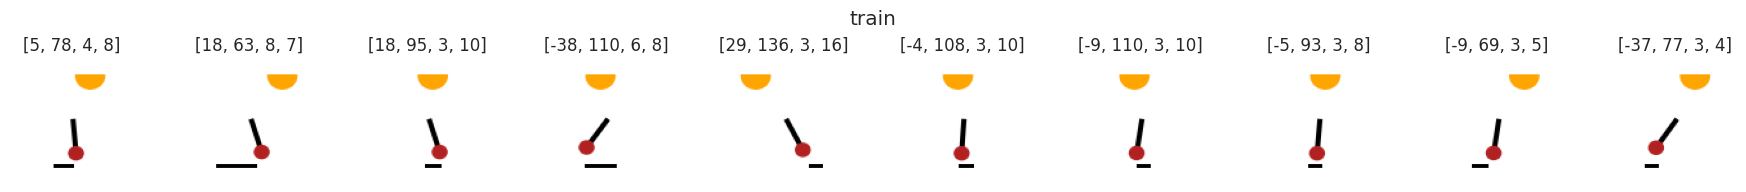

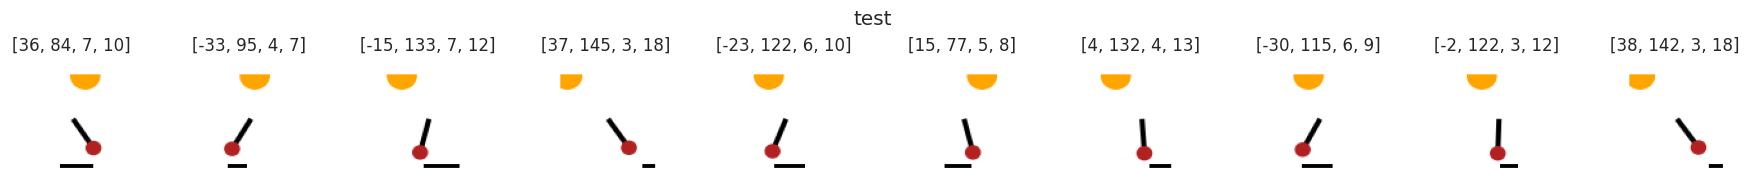

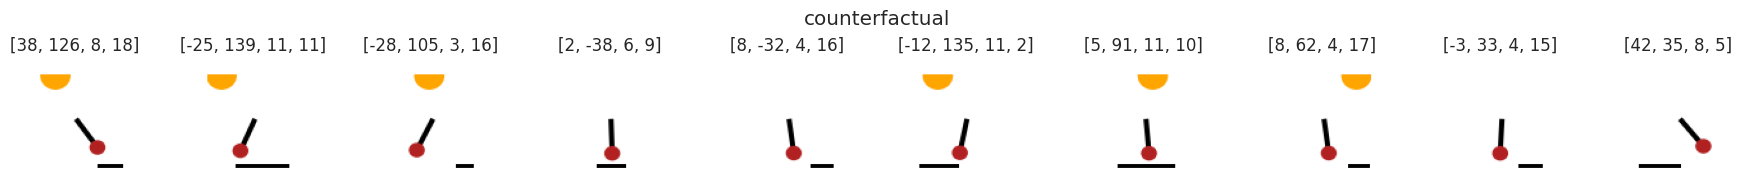

In [ ]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [train_dataset, test_dataset, cf_dataset]):
    plt.figure(figsize=(18, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label'].tolist()))
        plt.axis('off')
    plt.suptitle(n, y=.95)
    plt.tight_layout()

In [ ]:
BS = 256
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=2) #, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=2)
cf_loader = DataLoader(cf_dataset, batch_size=BS, shuffle=False, num_workers=2)

### 2. Build CVAE

In [ ]:
# !pip install -q torchsummary
# from torchsummary import summary

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3456 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3456 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=96*6*6)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.Upsample((12, 12)),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 64, 3, 1, 1),
            nn.Upsample((24, 24)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((48, 48)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.Upsample((96, 96)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.first_layer(z).view((-1, 96, 6, 6))
        return self.upsampling_layers(x)

In [ ]:
# enc = Encoder()
# summary(enc, [(3, 96, 96), (4,)])
# dec = Decoder()
# summary(dec, (Z_DIM,))

In [ ]:
class CVAE(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    # def get_one_hot(self, labels):
    #     new_ys = []
    #     for i, label_length in enumerate(LABEL_SIZES):
    #         new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
    #         new_ys.append(new_y)
    #     new_ys = torch.cat(new_ys, -1)
    #     return new_ys.to(torch.float32)

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, labels], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(torch.cat([z, labels], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 3. Inference (973 epochs, all combs)

In [ ]:
pyro.clear_param_store()
USE_CUDA = torch.cuda.is_available()
vae = CVAE(z_dim=Z_DIM, p=0.1, use_cuda=USE_CUDA)
vae.load_state_dict(torch.load('/content/drive/MyDrive/thesis/pendulum/vae_06_05_exp1.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae.train(False);

#### Clouds


In [ ]:
labels = []
z_all = []
for batch in test_loader:
    x = batch['img']
    l = batch['label']
    labels.append(l.detach().numpy())
    z = vae.encoder(x, l)[0].detach().numpy()
    z_all.append(z)

labels = np.concatenate(labels)
z_all = np.vstack(z_all)

In [ ]:
# df = pd.DataFrame(np.concatenate([z_all, labels], axis=1),
#              columns=['z'+str(i) for i in range(3)] + ['y'+str(i) for i in range(4)])

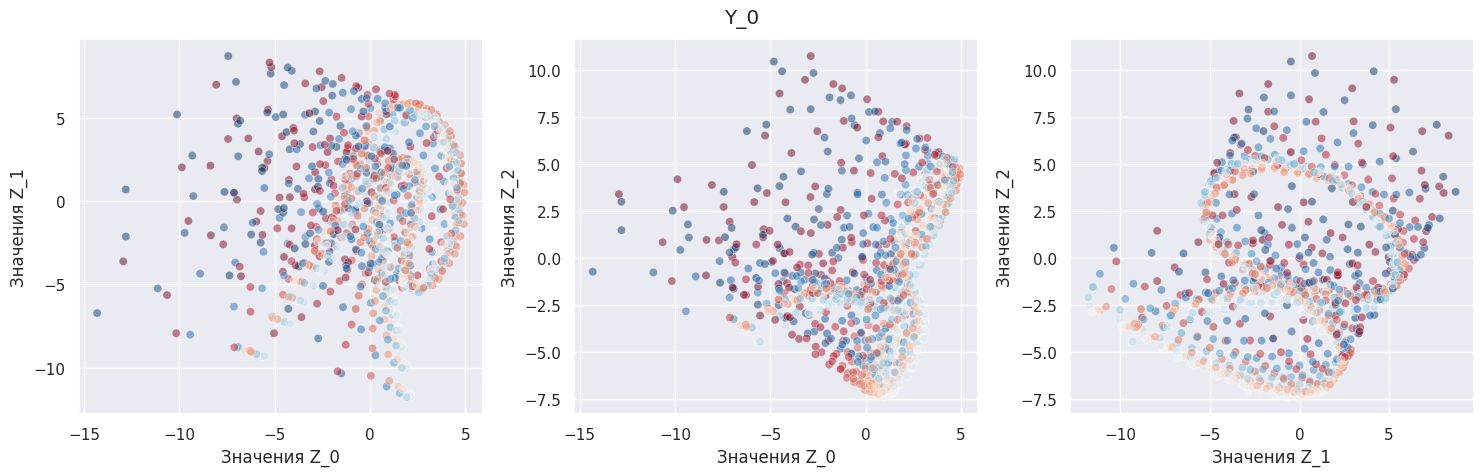

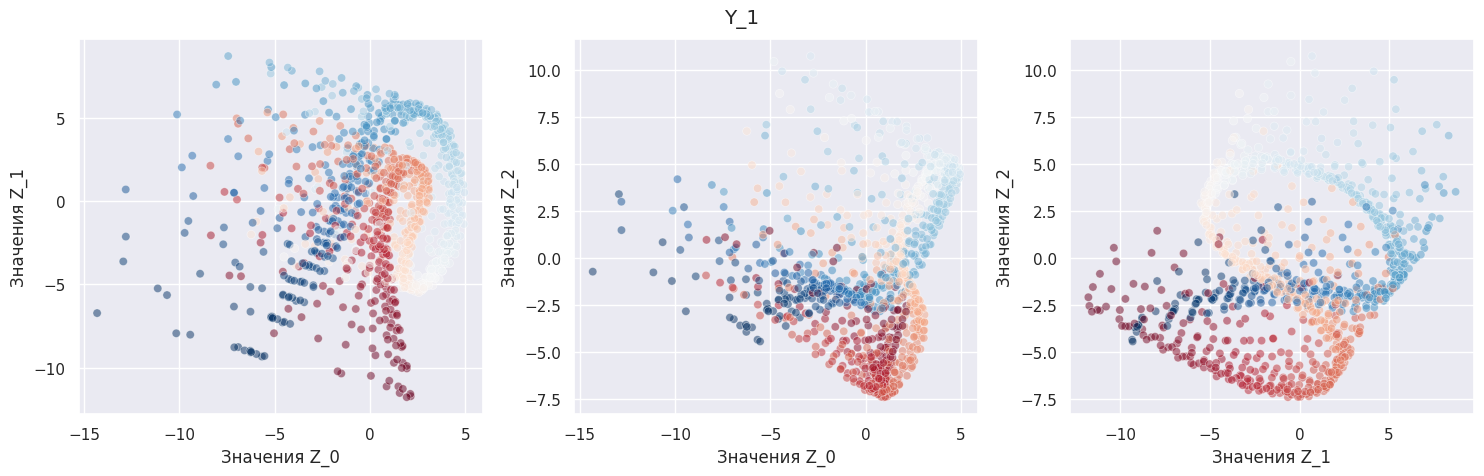

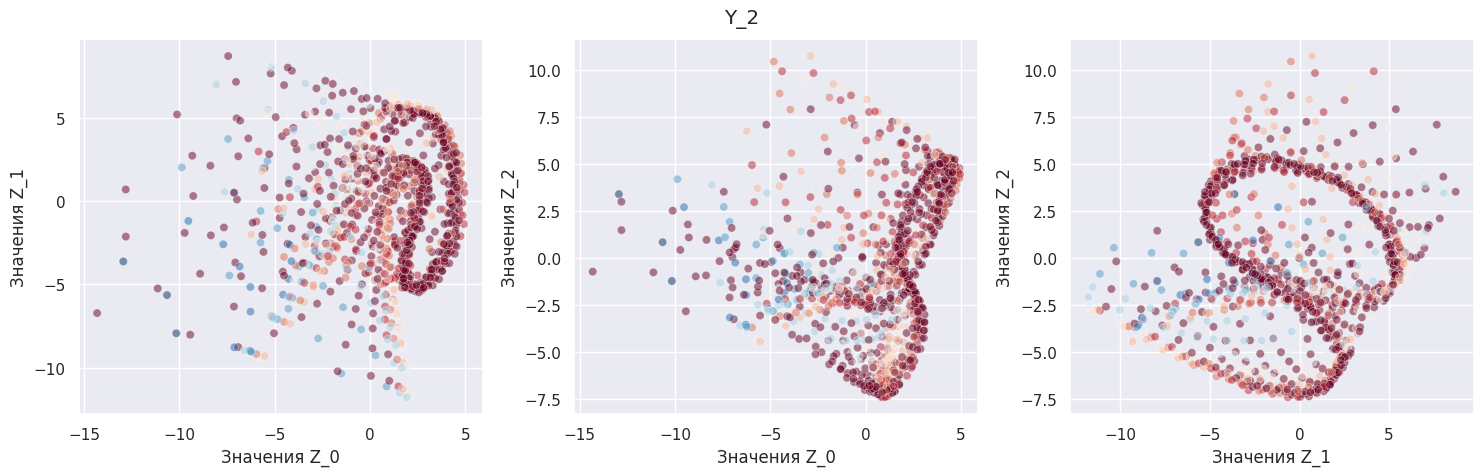

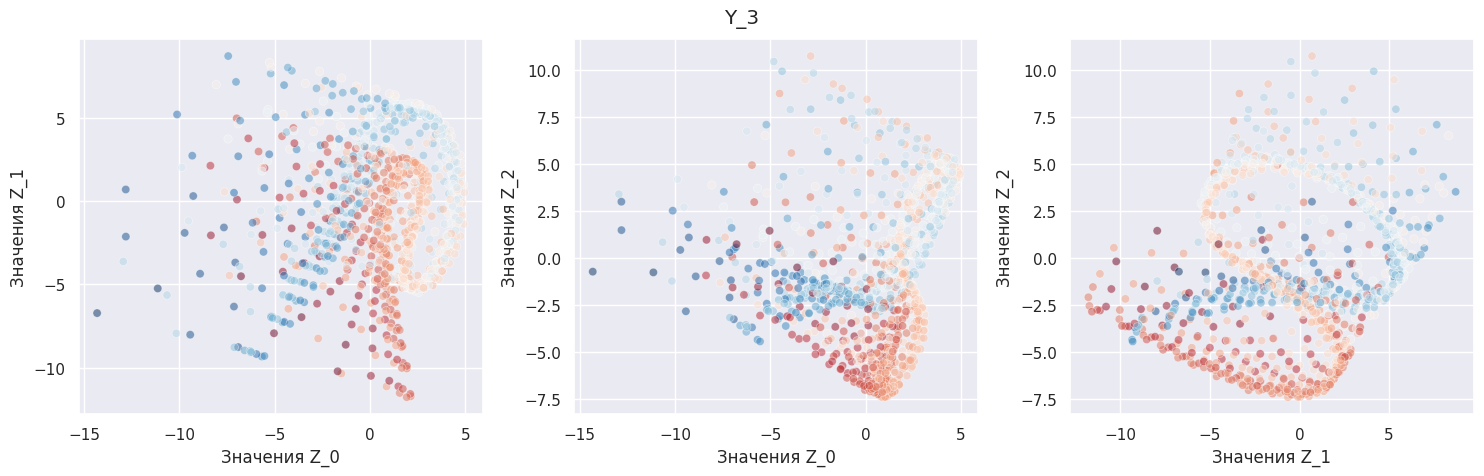

In [ ]:
for Y in range(4):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    combs = [[0, 1], [0, 2], [1, 2]]
    for i, comb in zip(range(3), combs):
        sns.scatterplot(x=z_all[:, comb[0]], y=z_all[:, comb[1]], c=labels[:, Y], alpha=0.5, ax=axes[i], cmap='RdBu')
        axes[i].set_xlabel('Значения Z_'+str(comb[0]))
        axes[i].set_ylabel('Значения Z_'+str(comb[1]));
    plt.suptitle('Y_'+str(Y), y=.95)
    plt.tight_layout()

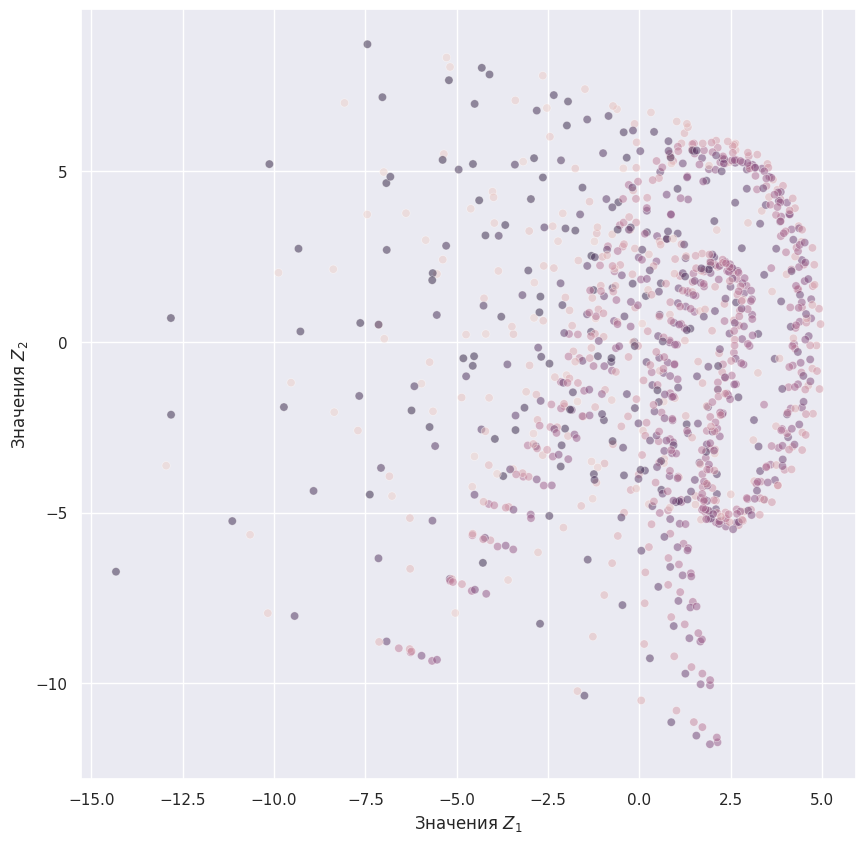

In [ ]:
plt.figure(figsize=(10, 10))
# plt.scatter(z_all[:, 0], z_all[:, 1], c=labels[:, 0], cmap='Set1', alpha=0.5, s=10)
sns.scatterplot(x=z_all[:, 0], y=z_all[:, 1], hue=labels[:,0], alpha=0.5)
# style=labels[:,1], size=labels[:,2],
plt.legend([],[], frameon=False)
plt.xlabel('Значения $Z_1$')
plt.ylabel('Значения $Z_2$');

In [ ]:
from scipy.special import expit
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [ ]:
def to_alpha(img):
    img = np.concatenate([np.array(img), 0.5 * np.ones(shape=(1, *img.shape[1:]))])
    return img.transpose((1, 2, 0))

def create_data_image(
    vae,
    data_loader,
    ymin=-4,
    ymax=4,
    do_expit=False,
    max_pictures=None,
    figsize=(20, 20),
    zoom=0.6,
    fname=None,
    dpi=200,
    axis=False,
    xlabel='',
    ylabel='',
    title=''
):

    with sns.axes_style('whitegrid' if axis else 'white'):
        fig, ax = plt.subplots(figsize=figsize)
        n_pictures = 0

        for i, batch in enumerate(data_loader):
            x, l = batch['img'], batch['label']
            y = vae.encoder(x, l)[0].detach().numpy()
            if do_expit:
                y = expit(y)

            for i in range(len(x)):
                img = to_alpha(x[i].detach().numpy())
                imagebox = OffsetImage(normalize(img), zoom=zoom)
                ab = AnnotationBbox(imagebox, (y[i, 0], y[i, 1]), frameon=False)
                ax.add_artist(ab)
            if i > 20:
                break

        plt.xlim((ymin, ymax))
        plt.ylim((ymin, ymax))
        if not axis:
            plt.axis('off')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()

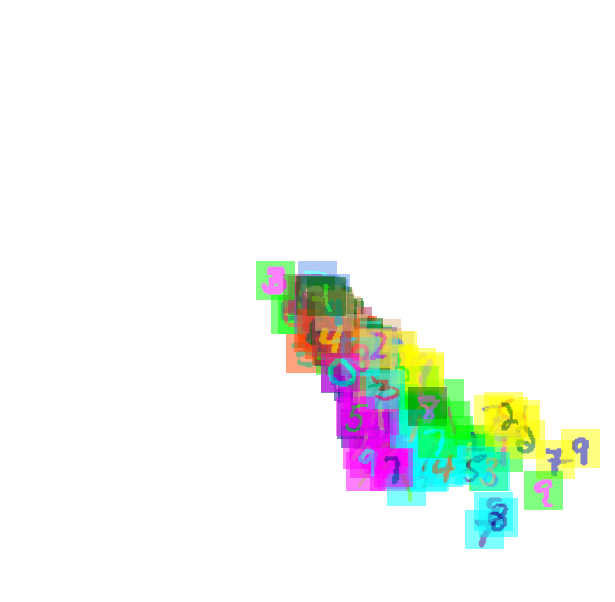

In [ ]:
create_data_image(vae, test_loader, figsize=(7, 7), zoom=1)

### 4. Other versions

In [ ]:
!mkdir models
!unzip -q /content/zdim2_models.zip -d models
import os

paths = os.listdir('/content/models')
paths = [paths[2]] + paths[3:] + paths[:2]

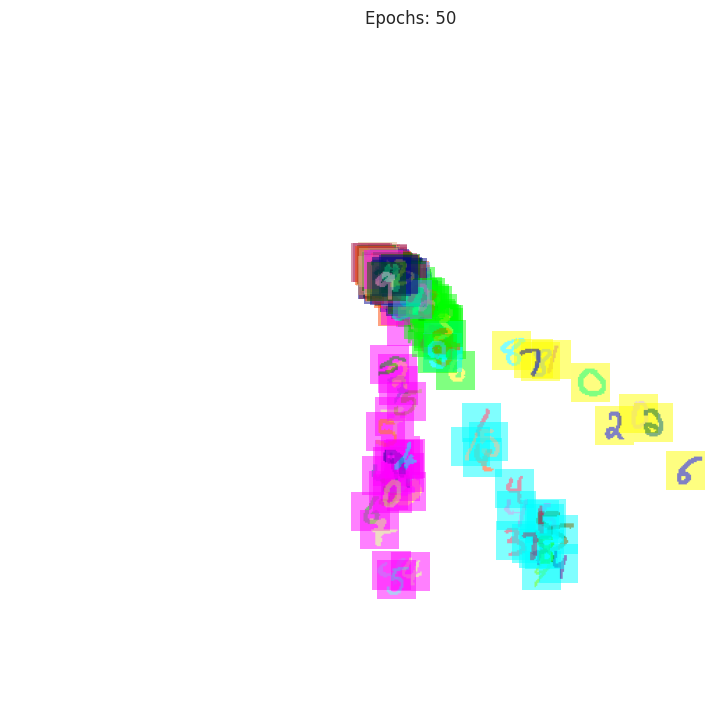

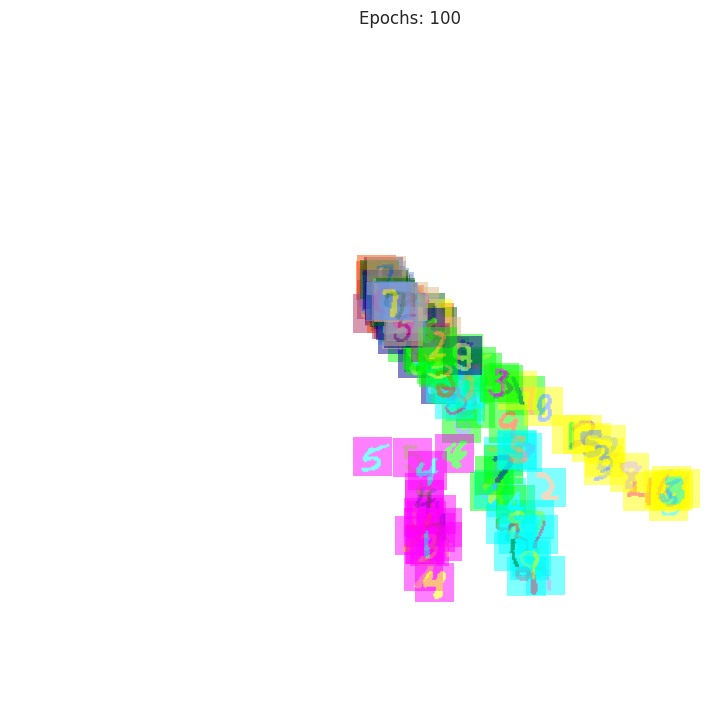

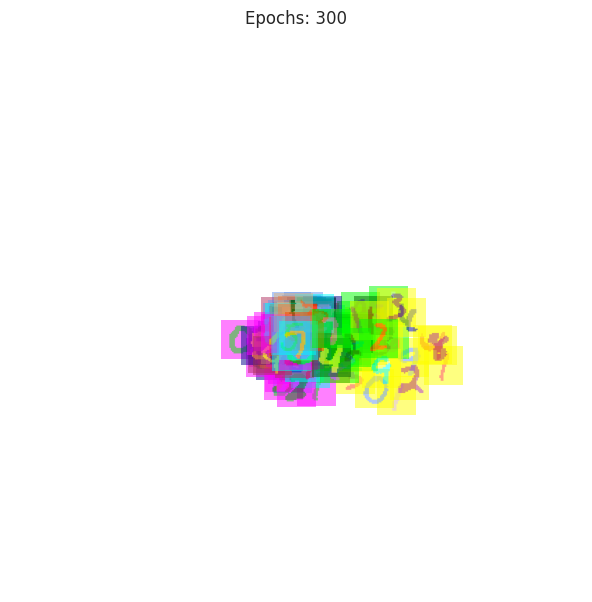

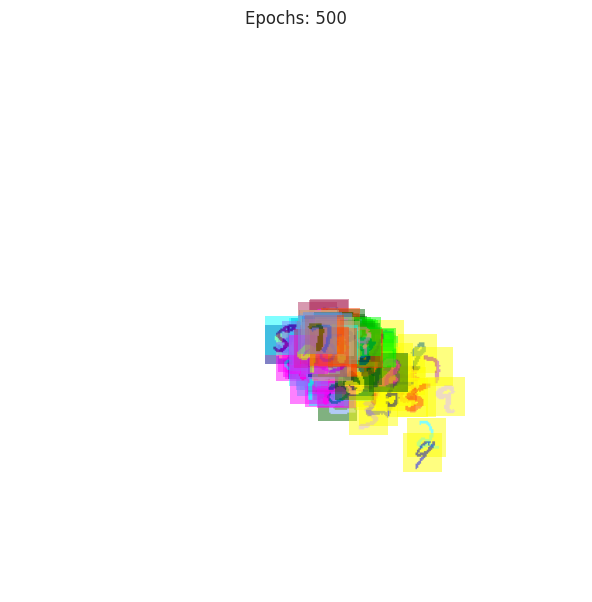

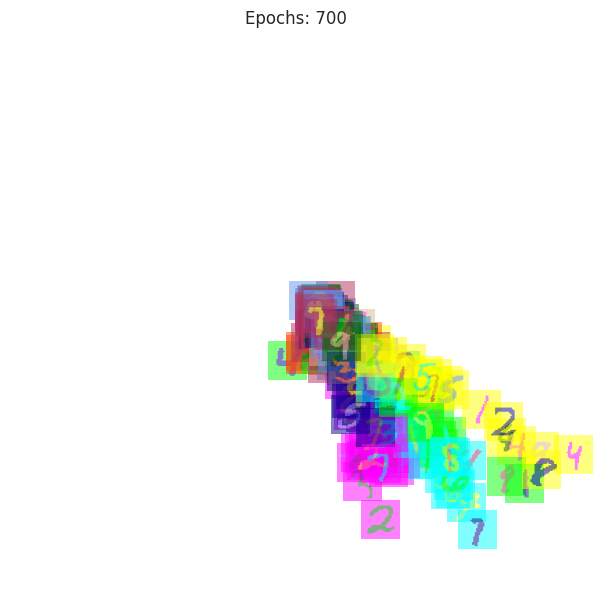

In [ ]:
for f, epochs in zip(os.listdir('/content/models'), [50, 100, 300, 500, 700]):
    pyro.clear_param_store()
    vae = CVAE_GAN(p=0.2, use_cuda=torch.cuda.is_available())
    vae.load_state_dict(torch.load(f, map_location='cpu'))
    create_data_image(vae, test_loader, figsize=(7, 7), zoom=1, title="Epochs: "+str(epochs))